In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import random
import pickle
from xgboost import XGBClassifier
import time
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import NearestNeighbors

/home/savoure_gael/.local/lib/python3.5/site-packages/xgboost/__init__.py:28: FutureWarning: Python 3.5 support is deprecated; XGBoost will require Python 3.6+ in the near future. Consider upgrading to Python 3.6+.
  FutureWarning)


## Functions

The following function gives the score base on the ROC curve for a threshold of $10^{-4}$

In [3]:
def score_for_threshold(threshold, yvalid_sorted):
    N = int(np.sum(yvalid_sorted == 0))
    P = int(np.sum(yvalid_sorted == 1))
    FP = 0
    TP = 0
    for i in range(len(yvalid_sorted) - 1, -1, -1):
        if (yvalid_sorted[i] == 1):
            TP = TP + 1
        else:
            FP = FP + 1
        if (float(FP / N) > 10**-4):
            FP = FP - 1
            break
    return TP / P

In order for me to understand better the scoring process, I chose to rewrite it manually (inspired from https://docs.eyesopen.com/toolkits/cookbook/python/plotting/roc.html)

In [4]:
def get_rates(yvalid_sorted):
    tpr=[0.0]
    fpr=[0.0]
    nb_simil=np.sum(yvalid_sorted)
    nb_not_simil=len(yvalid_sorted)-nb_simil
    foundSimil=0
    foundNotSimil=0
    for idx in range(len(yvalid_sorted)-1,-1,-1):
        if(yvalid_sorted[idx]==1):
            foundSimil+=1
        else:
            foundNotSimil+=1
        # in computing the rates every iteration, it's like we set the
        # threshold just above the current value of foundSimil
        tpr.append(foundSimil/float(nb_simil))
        fpr.append(foundNotSimil/float(nb_not_simil))
    return tpr, fpr

In [5]:
def plotRoc(fpr,tpr):
    plt.figure(figsize=(4, 4), dpi=80)
    plt.xlabel("FPR", fontsize=14)
    plt.ylabel("TPR", fontsize=14)
    plt.title("ROC Curve", fontsize=14)
    # MANUAL PLOT: tpr, fpr = get_rates(yvalid_sorted_with_predict) # MANUAL
    plt.plot(fpr, tpr, linewidth=2)
    plt.axvline(x=threshold, c='r')

Some useful functions:

In [6]:
def loadModel(modelName):
    return pickle.load(open(modelName, 'rb'))

def dumpModel(model, modelName):
    pickle.dump(model, open(modelName, 'wb'))

def loadTestData(xtest_path):
    x = pd.read_csv(xtest_path)
    return x

The following function takes several parameters, among them:
- UseRandomLoad: if activated, we will randomly pick some rows in the file
- Use RandomAfterLoad

In [7]:
def loadTrainingData(UseRandomLoad, UseRandomAfterLoad, xtrain_path, ytrain_path, nb_rows_load,
             nb_rows_after_load, random_state, percent_valid):

    nb_rows_train=int(nb_rows_load*percent_valid)

    if UseRandomLoad:
        random.seed(0)
        n = sum(1 for line in open(XTRAIN_PATH)) - 1
        skip = sorted(random.sample(range(1,n+1),nb_rows_load))
        x = pd.read_csv(XTRAIN_PATH, skiprows=skip)
        y = pd.read_csv(YTRAIN_PATH, skiprows=skip)
    else:
        x = pd.read_csv(XTRAIN_PATH, delimiter=',', nrows=nb_rows_load)
        y = pd.read_csv(YTRAIN_PATH, delimiter=',', nrows=nb_rows_load)

    if UseRandomAfterLoad:
        x = x.sample(nb_rows_after_load, random_state=random_state)
        y = y.sample(nb_rows_after_load, random_state=random_state)
        nb_rows_train=int(nb_rows_after_load/2)

    xtrain=x[:nb_rows_train]
    ytrain=y[:nb_rows_train]

    xvalid=x[nb_rows_train:]
    yvalid=y[nb_rows_train:]

    return xtrain, ytrain, xvalid, yvalid

## Variables

In [8]:
UseRandomLoad=False
UseRandomAfterLoad=False
XTRAIN_PATH='xtrain_challenge.csv'
XTEST_PATH='xtest_challenge.csv'
YTRAIN_PATH='ytrain_challenge.csv'
nb_rows_load=9800000
nb_rows_after_load=100000
threshold=10**-4
percent_valid=0.5 # 1 => no validation

random_state=0
random_state_list=list(range(0,1))

## Load

In [9]:
xtrain, ytrain, xvalid, yvalid = loadTrainingData(UseRandomLoad=UseRandomLoad, UseRandomAfterLoad=UseRandomAfterLoad, xtrain_path=XTRAIN_PATH,
                                              ytrain_path=YTRAIN_PATH, nb_rows_load=nb_rows_load, nb_rows_after_load=nb_rows_after_load,
                                              random_state=random_state, percent_valid=percent_valid)
xtest = loadTestData(XTEST_PATH)
print("finished loading")

finished loading


## Data exploration

I ran first analysis just to study both sets (train / test) and make sure they have the same distribution.

I also wanted to make sure sampling would make sense.

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 1080x216 with 0 Axes>

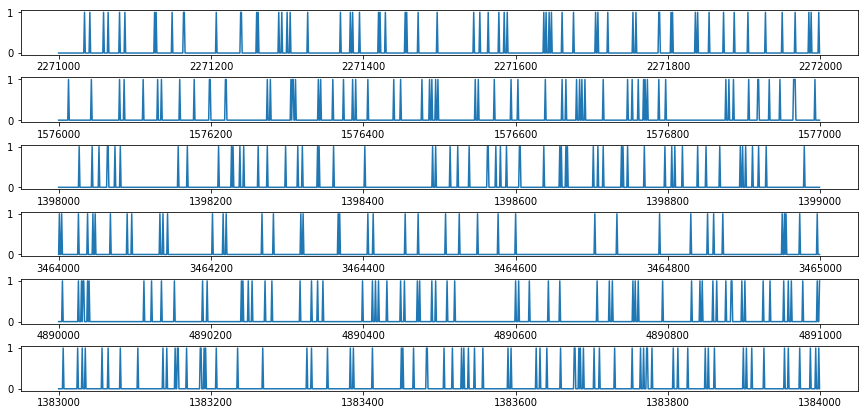

<Figure size 720x216 with 0 Axes>

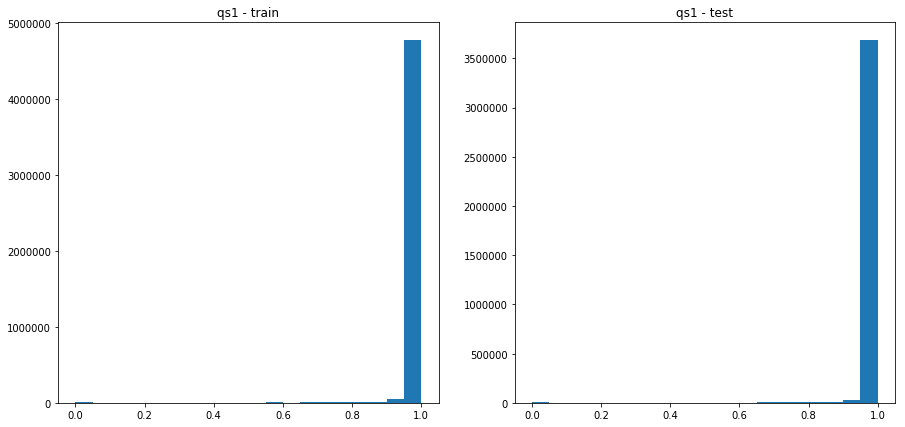

<Figure size 720x216 with 0 Axes>

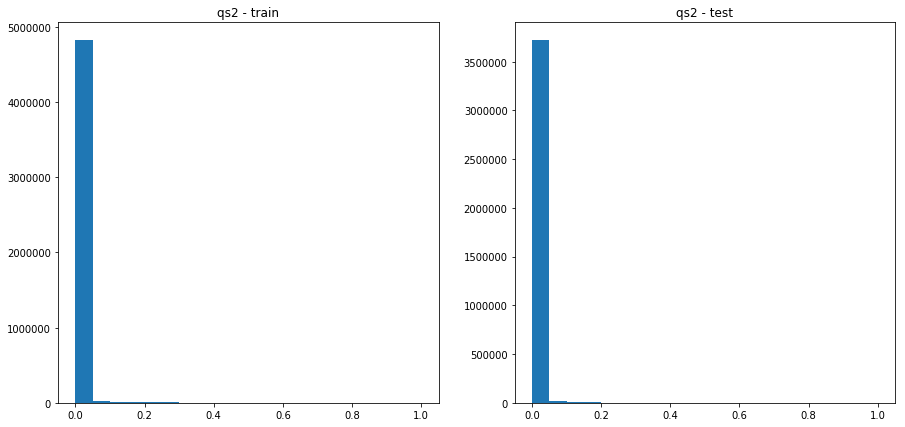

<Figure size 720x216 with 0 Axes>

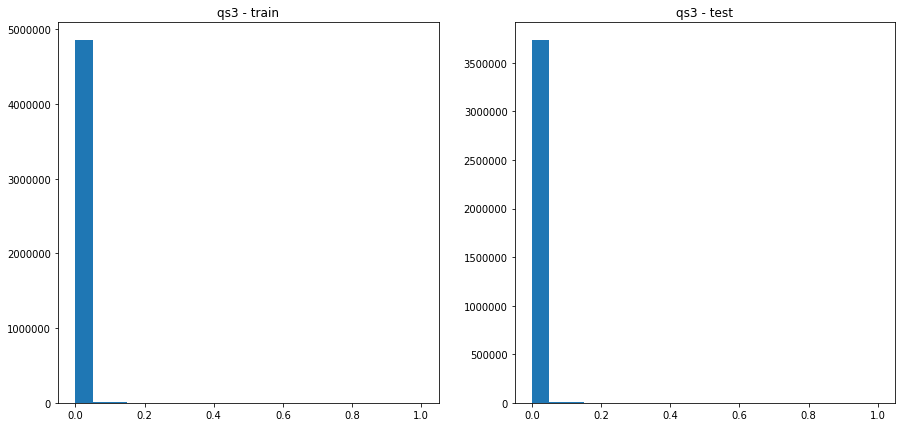

<Figure size 720x216 with 0 Axes>

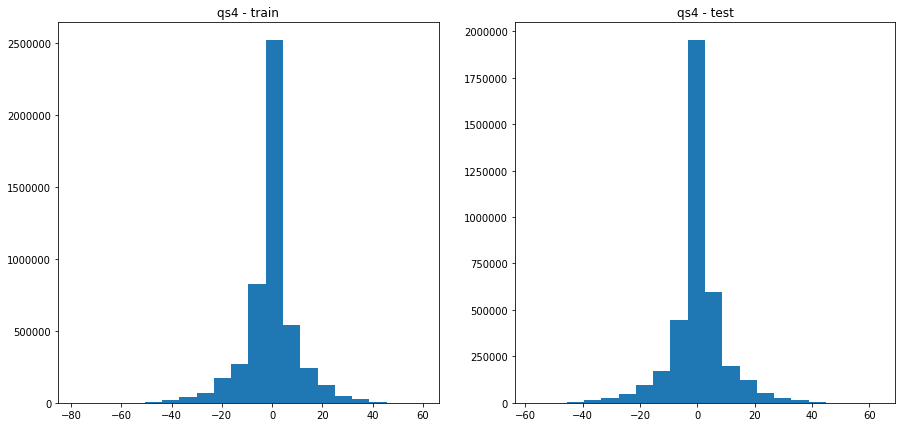

<Figure size 720x216 with 0 Axes>

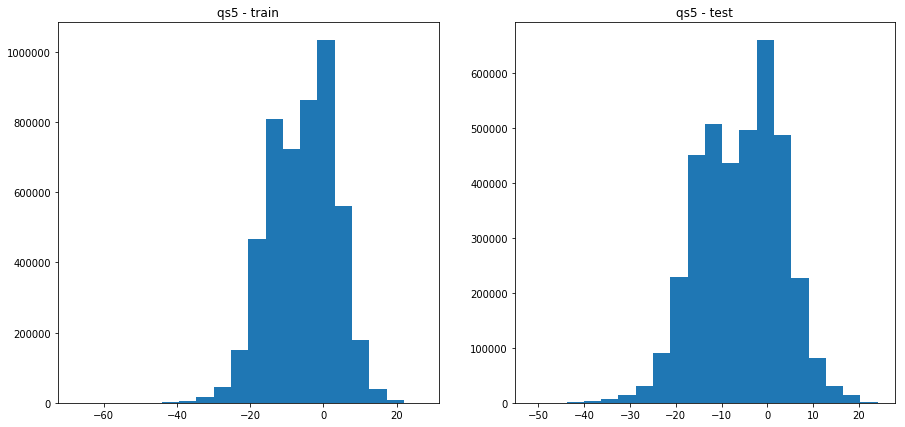

<Figure size 720x216 with 0 Axes>

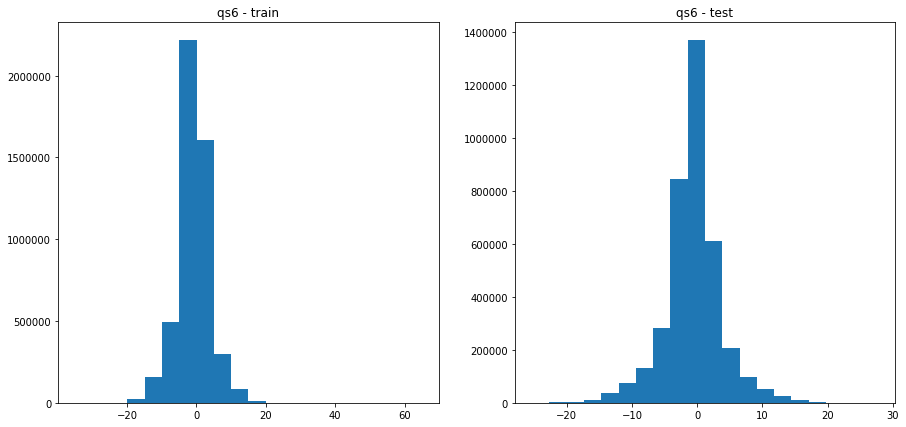

<Figure size 720x216 with 0 Axes>

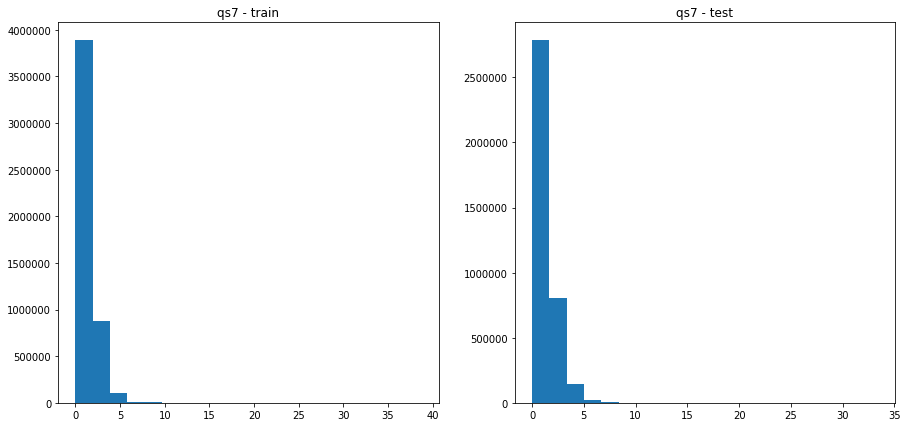

<Figure size 720x216 with 0 Axes>

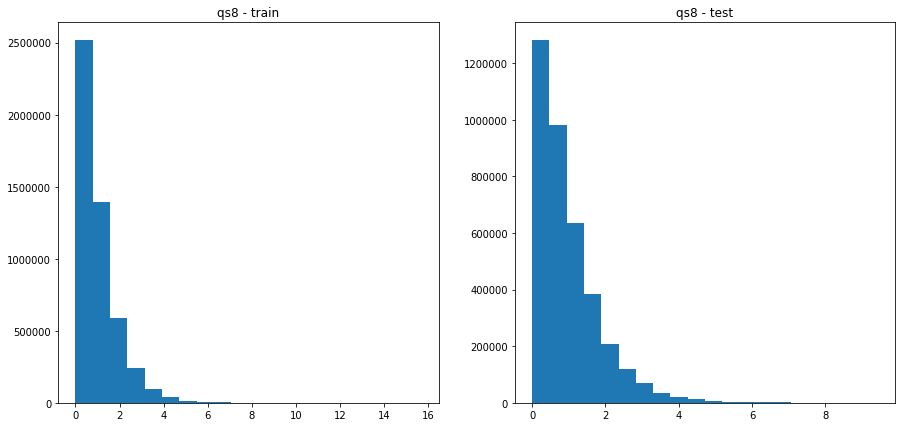

<Figure size 720x216 with 0 Axes>

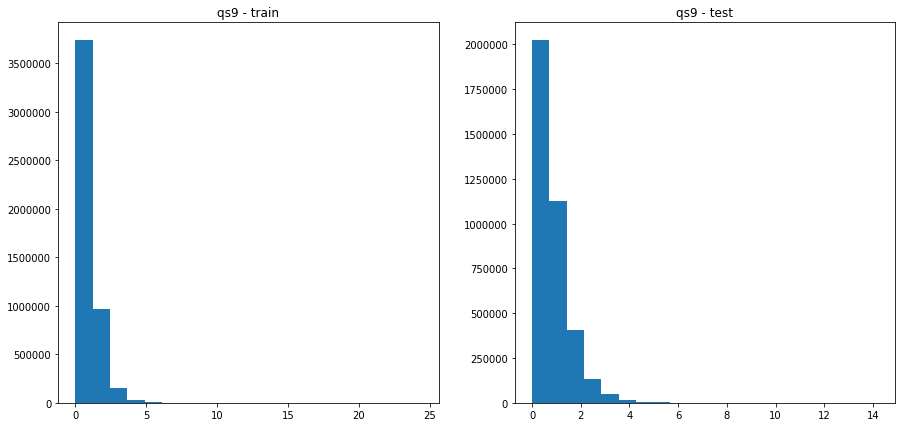

<Figure size 720x216 with 0 Axes>

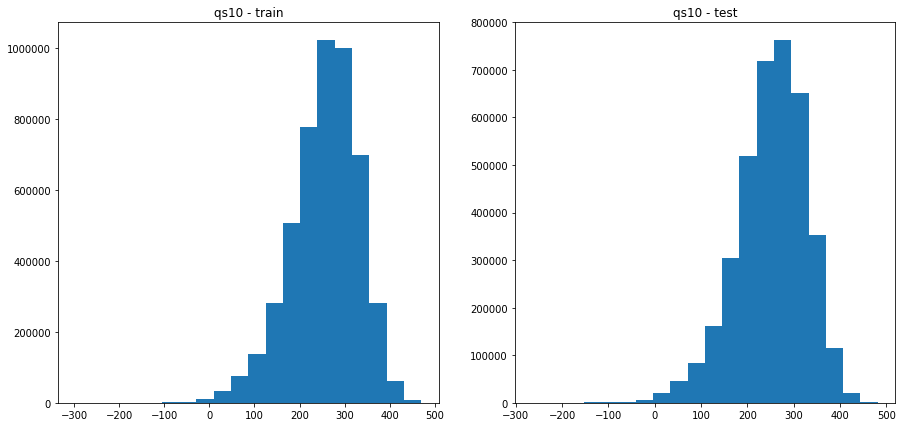

<Figure size 720x216 with 0 Axes>

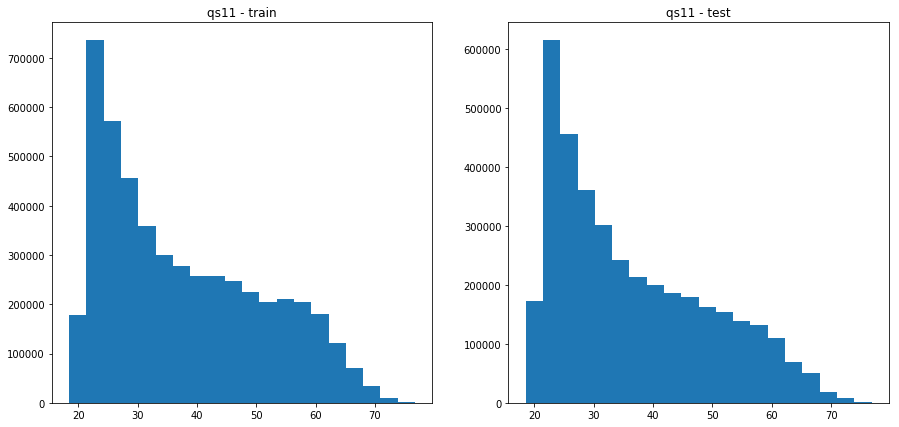

<Figure size 720x216 with 0 Axes>

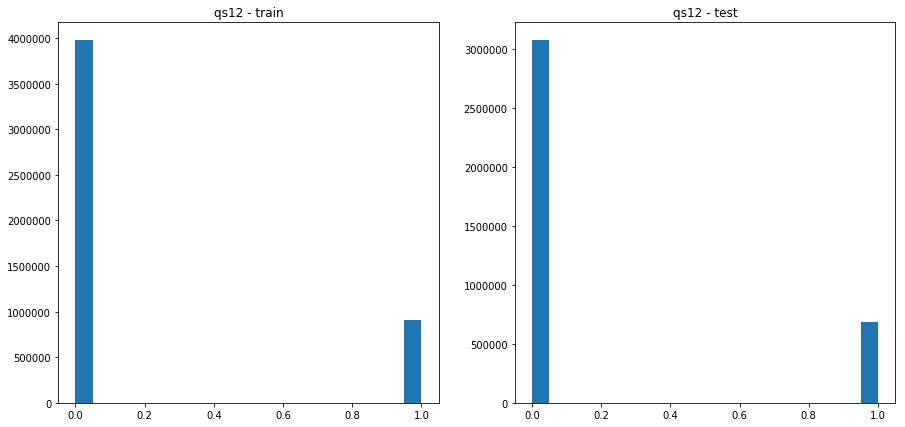

<Figure size 720x216 with 0 Axes>

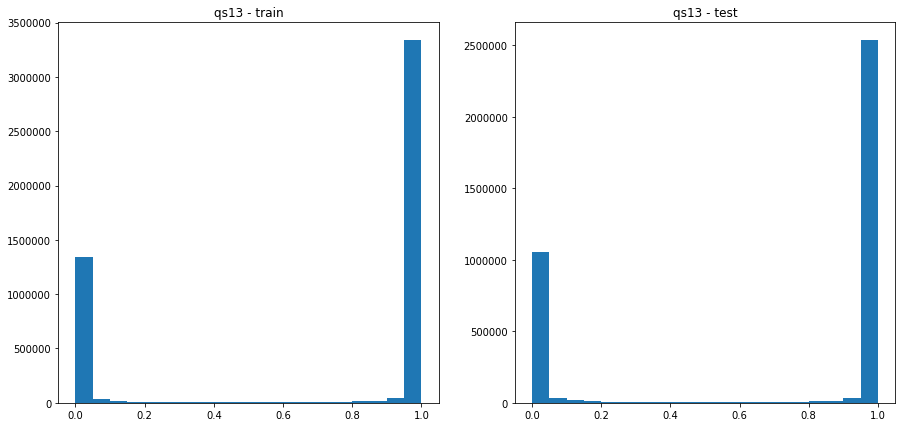

<Figure size 720x216 with 0 Axes>

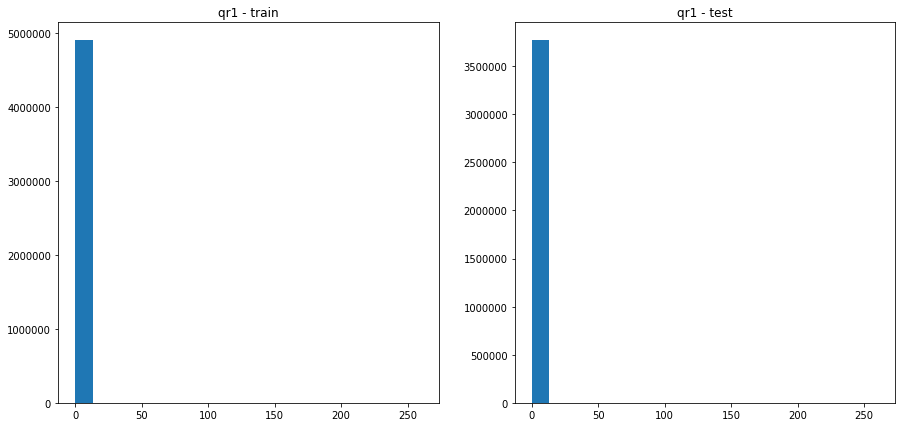

<Figure size 720x216 with 0 Axes>

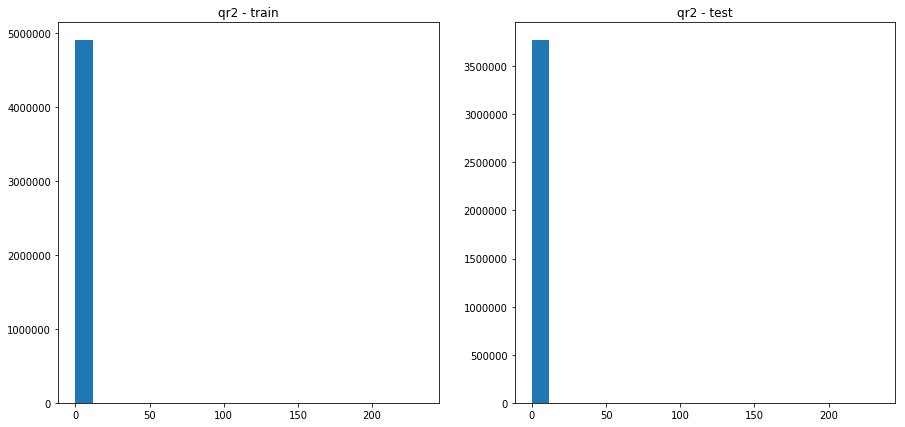

<Figure size 720x216 with 0 Axes>

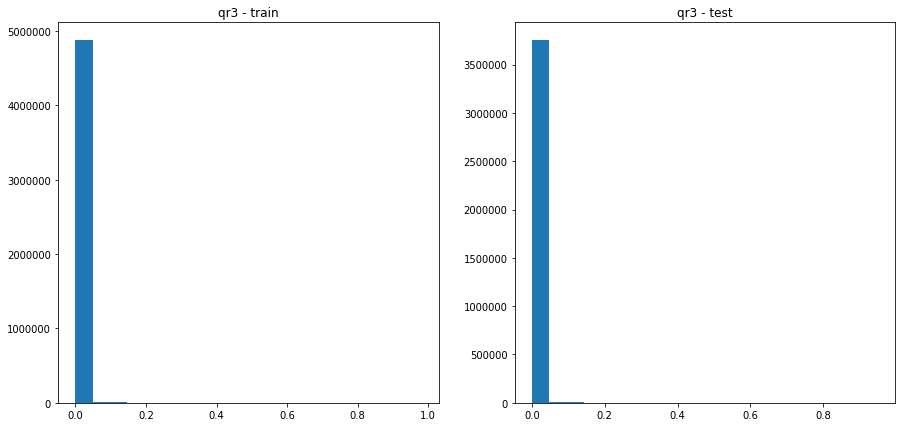

<Figure size 720x216 with 0 Axes>

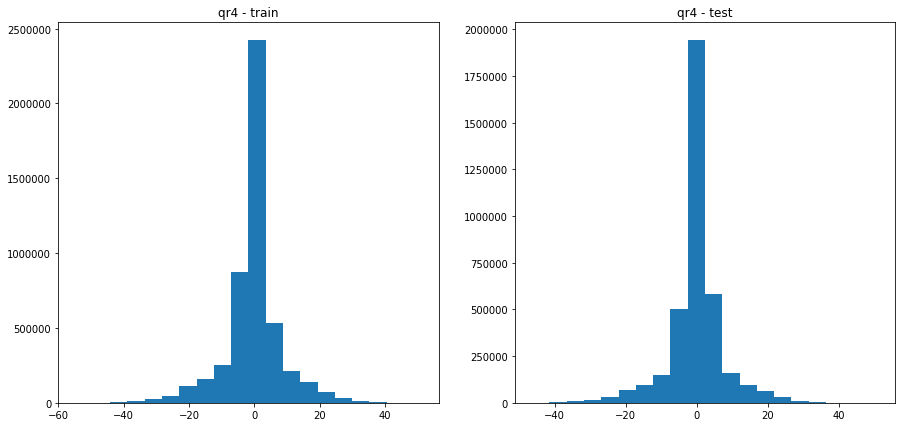

<Figure size 720x216 with 0 Axes>

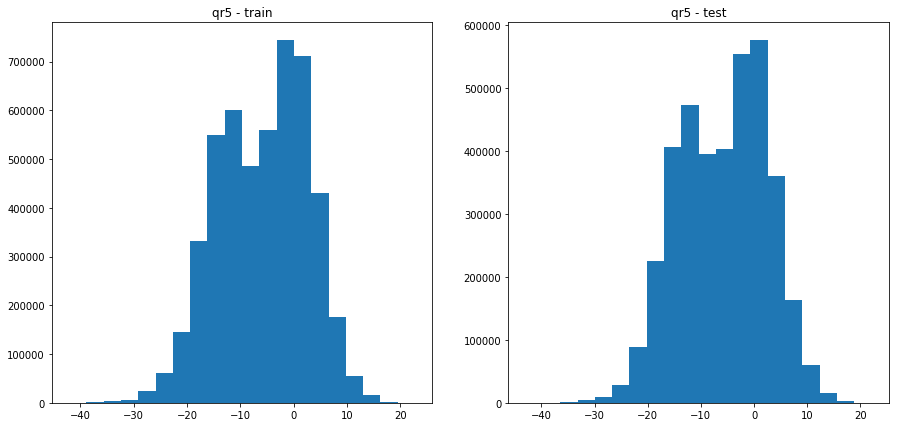

<Figure size 720x216 with 0 Axes>

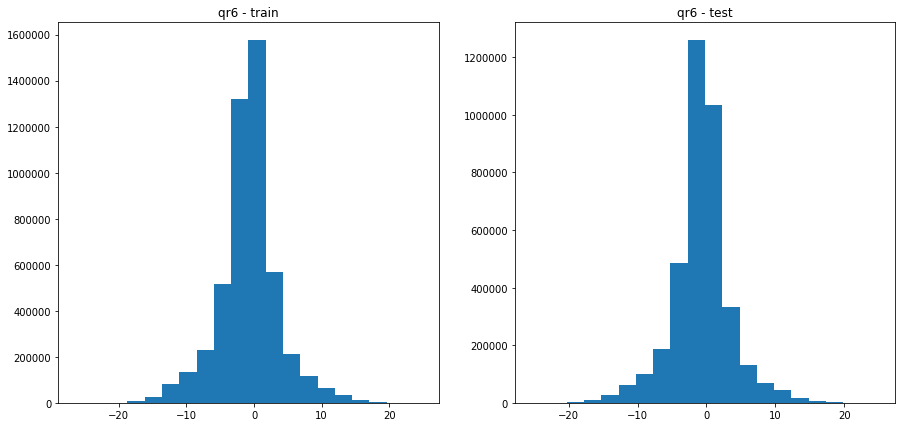

<Figure size 720x216 with 0 Axes>

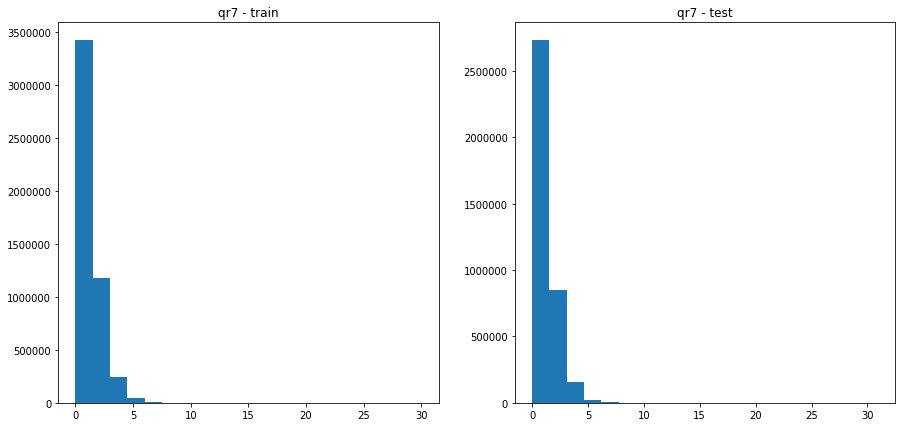

<Figure size 720x216 with 0 Axes>

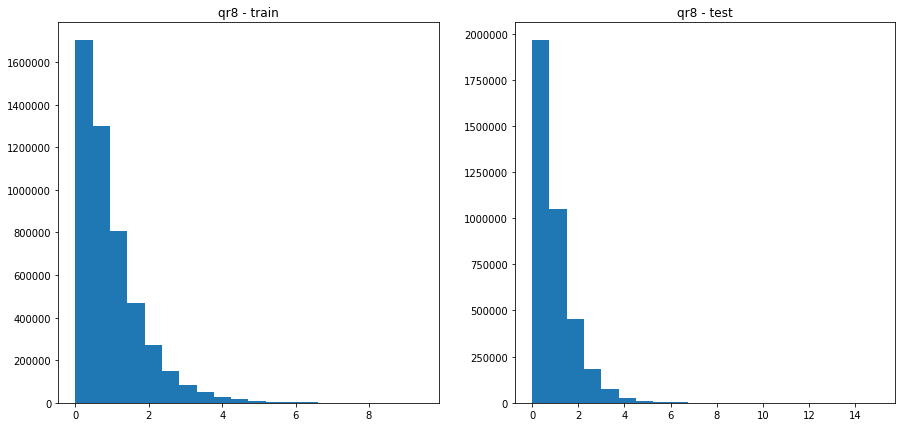

<Figure size 720x216 with 0 Axes>

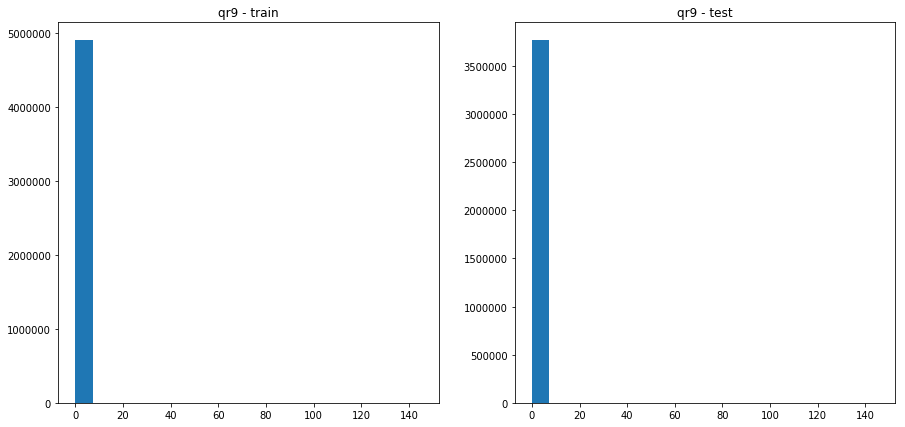

<Figure size 720x216 with 0 Axes>

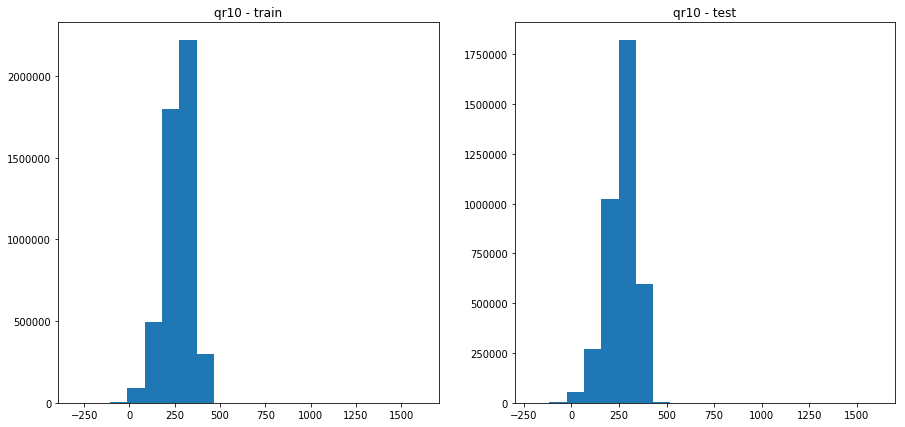

<Figure size 720x216 with 0 Axes>

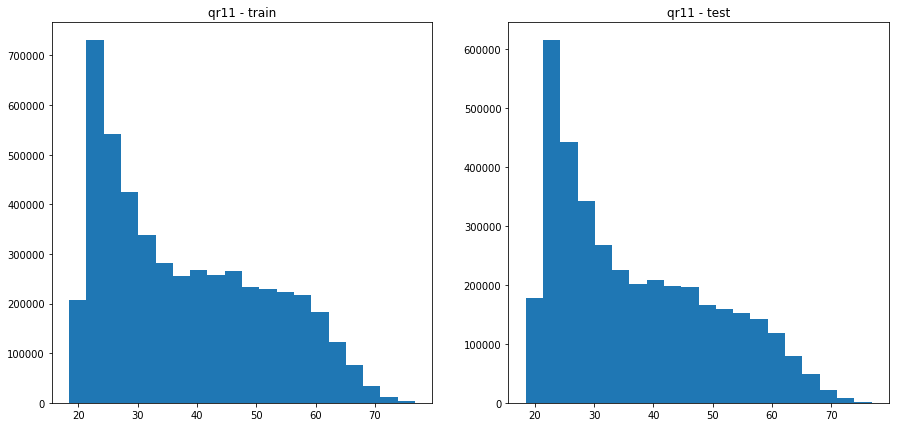

<Figure size 720x216 with 0 Axes>

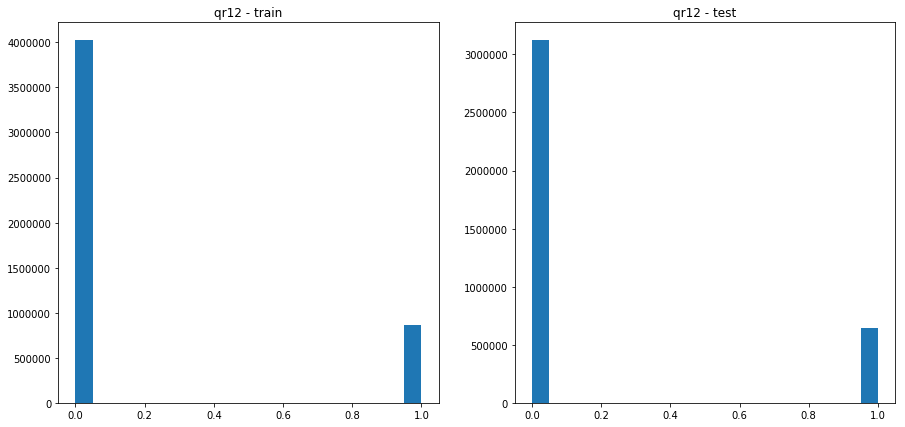

<Figure size 720x216 with 0 Axes>

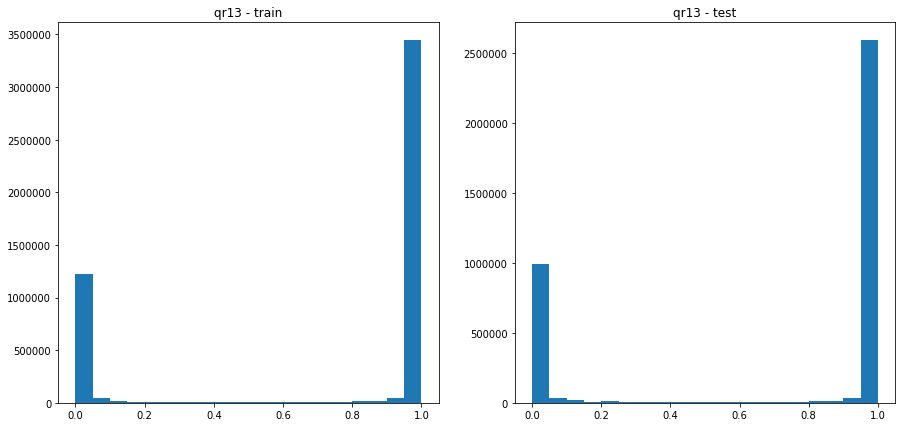

<Figure size 720x216 with 0 Axes>

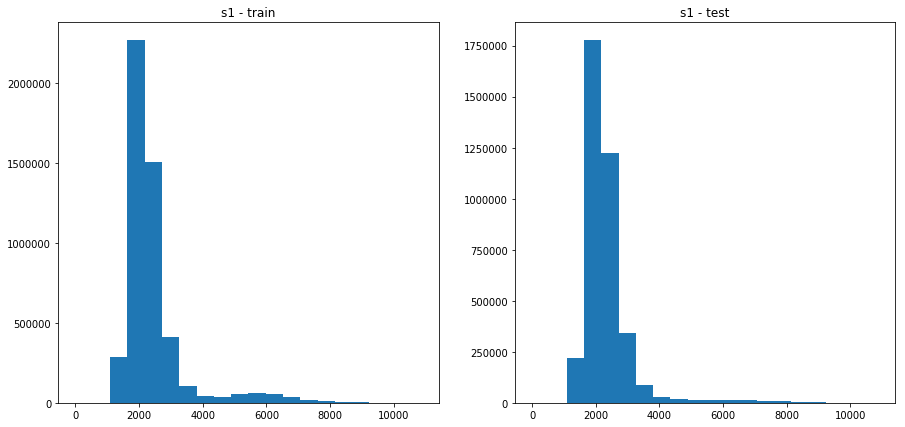

<Figure size 720x216 with 0 Axes>

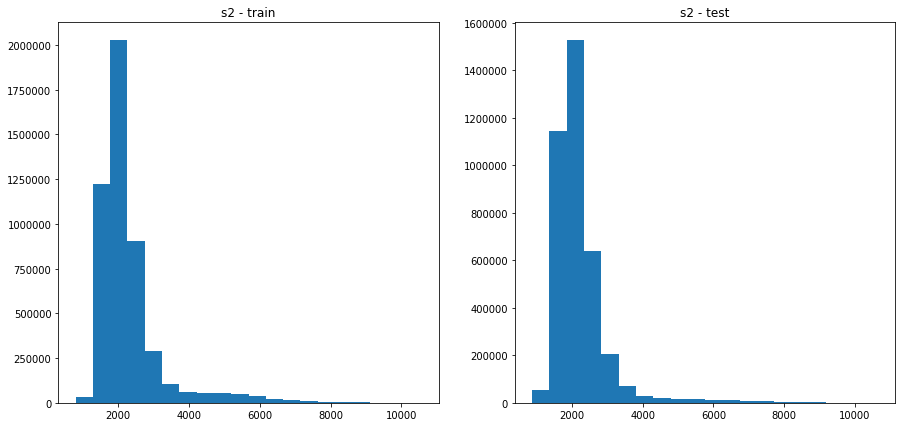

<Figure size 720x216 with 0 Axes>

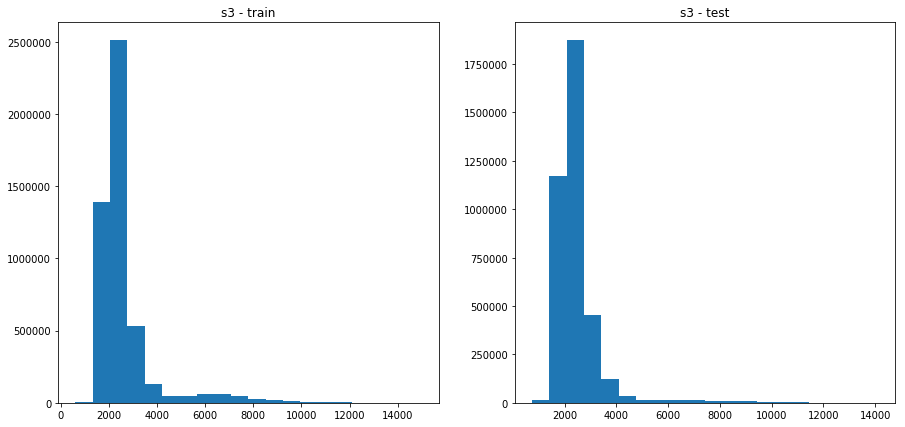

<Figure size 720x216 with 0 Axes>

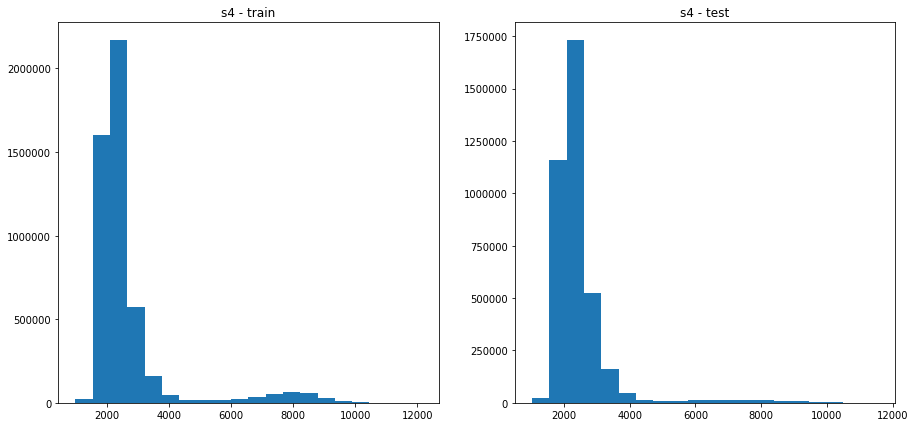

<Figure size 720x216 with 0 Axes>

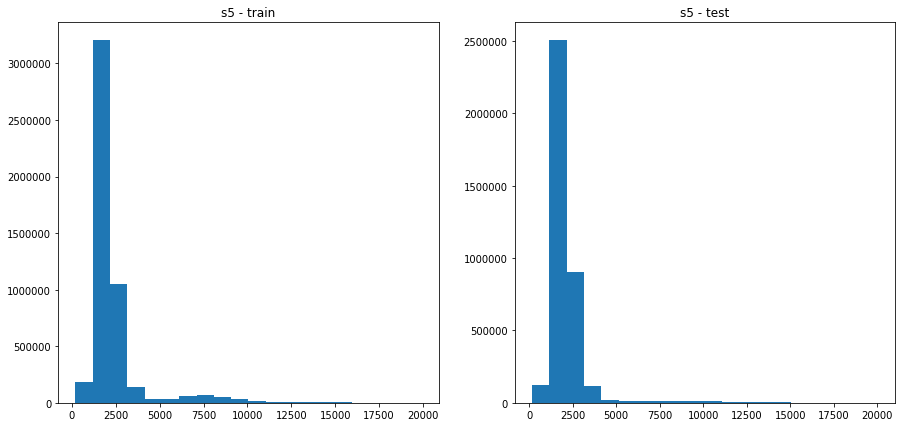

<Figure size 720x216 with 0 Axes>

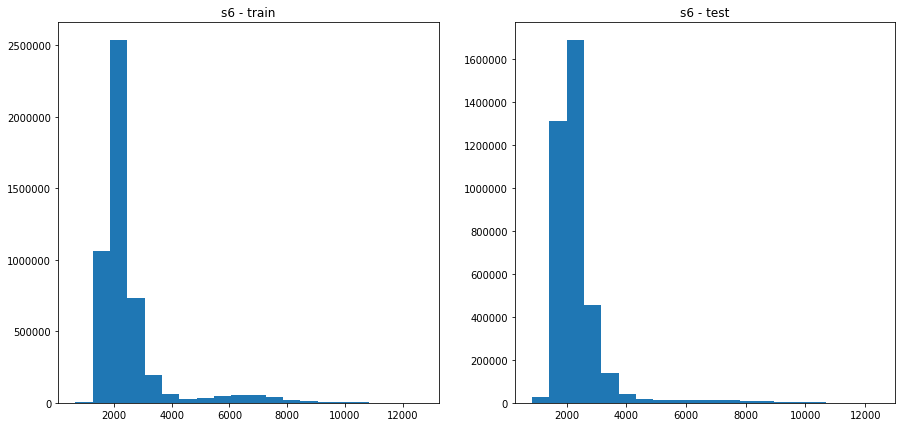

<Figure size 720x216 with 0 Axes>

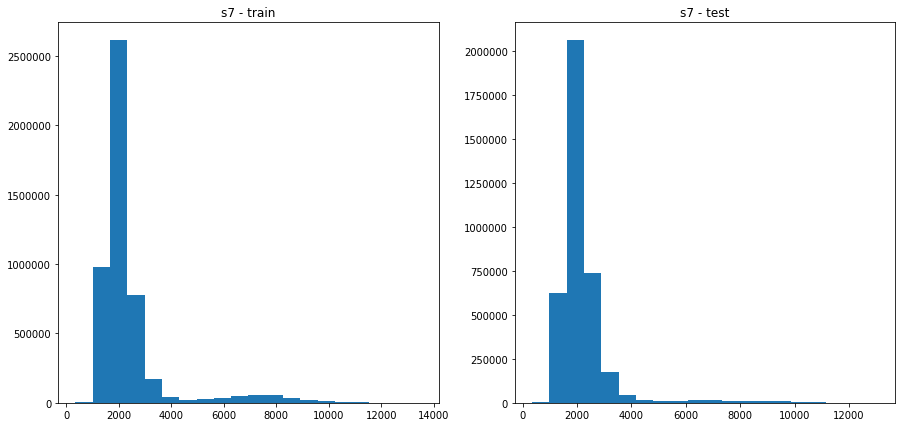

<Figure size 720x216 with 0 Axes>

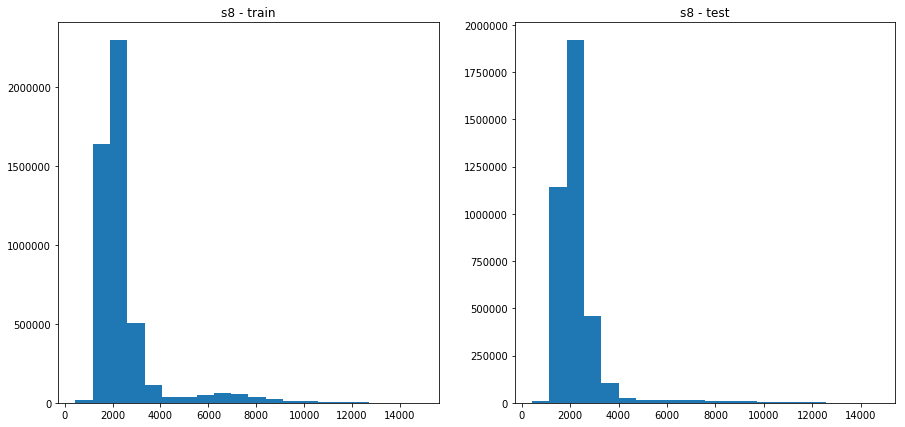

<Figure size 720x216 with 0 Axes>

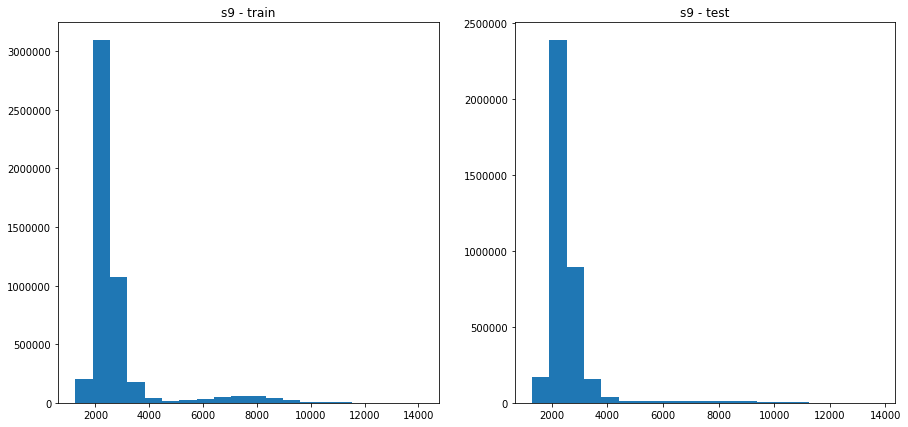

<Figure size 720x216 with 0 Axes>

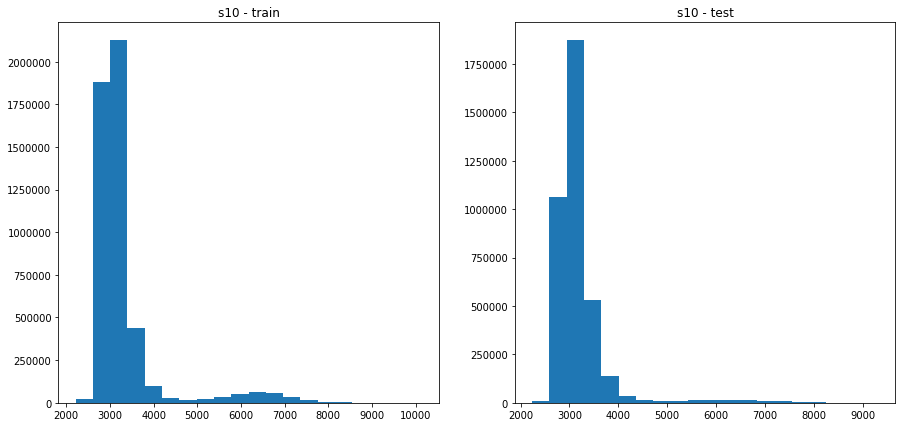

<Figure size 720x216 with 0 Axes>

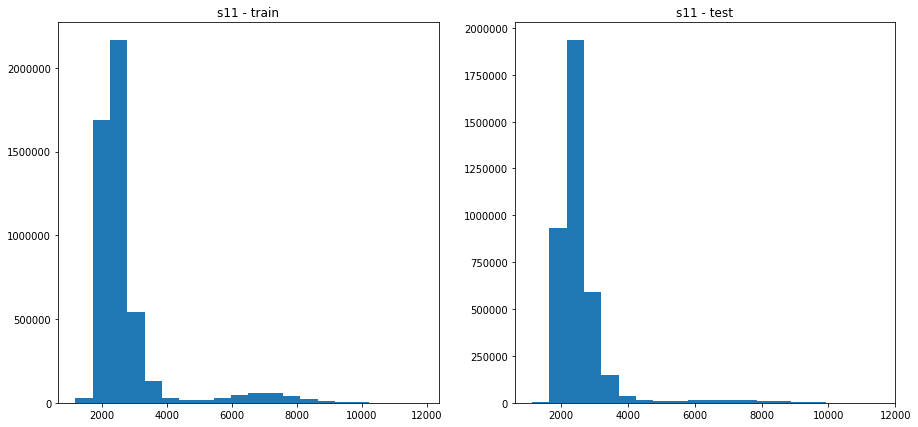

In [10]:
randomListOfIndexes = [random.randint(0, int(len(ytrain)/1000)) for iter in range(6)]

plt.figure(figsize=(15, 3))
fig, axs = plt.subplots(6, figsize=(15, 7))
fig.subplots_adjust(hspace=.5)
for idx, value in enumerate(randomListOfIndexes):
    axs[idx].plot(ytrain[value*1000:(value+1)*1000])

# Display of distributions
for idx, colName in enumerate(xtrain.columns):

    plt.figure(figsize=(10, 3))
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    axs[0].hist(xtrain[colName], 20)
    axs[0].set_title(colName + " - train")

    axs[1].hist(xtest[colName], 20)
    axs[1].set_title(colName + " - test")

Display of key figures

In [12]:
trainMeans = []
testMeans = []
trainStd = []
testStd = []
for colName in xtrain.columns:
    trainMeans.append(np.mean(xtrain[colName]))
    testMeans.append(np.mean(xtest[colName]))
    trainStd.append(np.std(xtrain[colName]))
    testStd.append(np.std(xtest[colName]))

Text(0.5, 1.0, 'std of features')

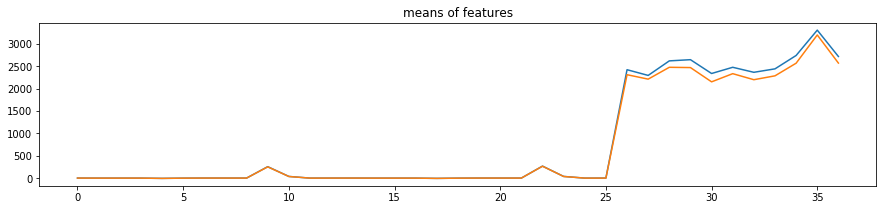

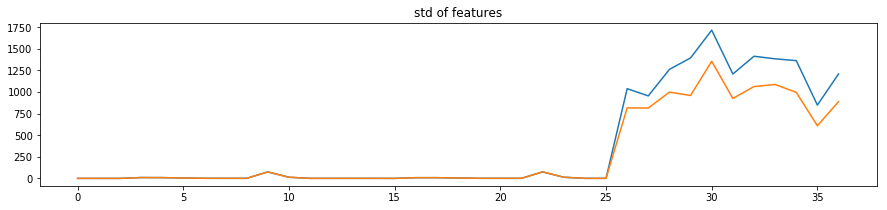

In [13]:
plt.figure(figsize=(15, 3))
plt.plot(trainMeans)
plt.plot(testMeans)
plt.title('means of features')

plt.figure(figsize=(15, 3))
plt.plot(trainStd)
plt.plot(testStd)
plt.title('std of features')

## Preprocessing - Nearest neighbors

One of my ideas was to select the closest points to the xtest from the xtrain. In doing so, this would save significant time during training and would allow the model to learn better. 

I used NearestNeighbors class that implements the Eucliean distance.

In [14]:
start_time = time.time()
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(np.array(xtrain))
print("{} seconds".format(round(time.time() - start_time,2)))

66.05 seconds


Quick test to see how it looks if we pick a random observation:

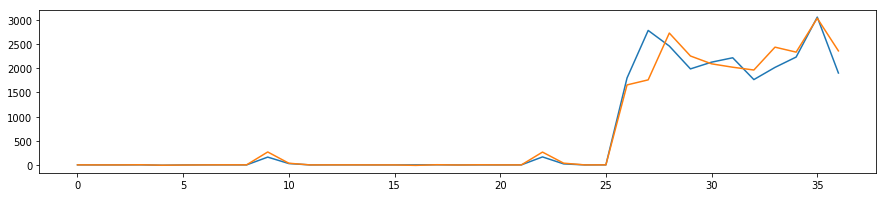

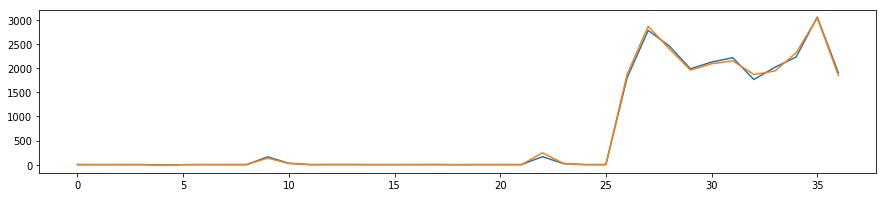

In [15]:
xt_one = np.array(xtest)[20]
xtrain_simil_idx=neigh.kneighbors(xt_one.reshape(1,-1), return_distance=False).ravel()[0]
x_simil_nn = np.array(xtrain)[xtrain_simil_idx]

x_simil_test = np.array(xtrain)[5]

plt.figure(figsize=(15, 3))
plt.plot(xt_one)
plt.plot(x_simil_test)

plt.figure(figsize=(15, 3))
plt.plot(xt_one)
plt.plot(x_simil_nn)

As we can see, the Nearest Neighbors allows to find very close observation.

The following are various ways I used to select the closest train set that would fit with the test set based on nearest neighbors. The main constraint here was the timing issue. I had to run <i>neigh.kneighbors</i> on each observations and this took very long time (even with vectorization). I also tried to use GPU libraries such as CuPy and Numba, but those were not compatible with scikit-learn functions.

In [ ]:
def findBestSamplePandas(x, y, xt):
    list_simil_idx = xt.apply(lambda x: neigh.kneighbors(np.array(x).reshape(1,-1), return_distance=False).ravel()[0], axis=1)

    x_simil = np.array(x)[list_simil_idx]
    y_simil = np.array(y)[list_simil_idx]
    return x_simil, y_simil

In [ ]:
def apply_nn_2(x_row):
    return neigh.kneighbors(x_row.reshape(1,-1), return_distance=False).ravel()[0]

In [ ]:
def findBestSampleNumpy(x, y, xt):
    list_simil_idx = np.apply_along_axis(apply_nn_2, 1, xt)
    np.savetxt('indexes-array.csv', list_simil_idx, fmt = '%i', delimiter=',')

    x_simil = np.array(x)[list_simil_idx]
    y_simil = np.array(y)[list_simil_idx]
    return x_simil, y_simil

In [11]:
start_time = time.time()
#xtrain_2, y_train_2 = findBestSampleTemp(xtrain, ytrain, xtest.head(1000))
print("{} seconds".format(round(time.time() - start_time,2)))

0.0 seconds


In [12]:
start_time = time.time()
np.apply_along_axis(apply_nn_2, 1, xtest.head(1000))
print("{} seconds".format(round(time.time() - start_time,2)))

0.0 seconds


As matching each observation from the test set took such a long time (I stopped after 8 hours running), I decided to use multithreading:

In [13]:
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import as_completed

In [14]:
start_time = time.time()
idx_list=[]
def bestSample(xt):
    try:
        idx = neigh.kneighbors(xt.reshape(1,-1), return_distance=False).ravel()[0]
        idx_list.append(idx)
    except:
        print("error")
    return 0
with ThreadPoolExecutor(max_workers = 20) as executor:
    results = executor.map(bestSample, np.array(xtest))
#np.savetxt('indexes-MT.csv', np.array(idx_list), fmt = '%i', delimiter=',')
print("{} seconds".format(round(time.time() - start_time,2)))

This took one hour to run. I saved results afterward and worked from this.

In [17]:
xtrain_new_idx = pd.read_csv('indexes-MT.csv', header=None)

In [18]:
xtrain_new = np.array(xtrain)[xtrain_new_idx]

In [21]:
xtrain_new = xtrain_new.reshape(len(xtrain_new), 37)

In [23]:
ytrain_new = np.array(ytrain)[xtrain_new_idx]

In [24]:
ytrain_new.shape

(3768311, 1, 1)

In [25]:
ytrain_new = ytrain_new.reshape(len(ytrain_new), 1)

In [26]:
ytrain_new.shape

(3768311, 1)

## Model

When I wanted to do sampling in order to perform multiple tests quickly, I included the model part in a loop:

In [ ]:
score_list=[]

for random_state in random_state_list:

This gave me several scores and I could do an average to get an overall result. Also, it allows me to not spend too much time with the grading function (that uses a loop).

## Logisitic regression

I perform several tests, among them:
- use of solver newton-cg
- use of solver lbfgs
- iterations 100,1000
- sampling/no sampling

In [ ]:
clf = LogisticRegression(solver='newton-cg')

## XGBoost

XGBoost gave much better results than logistic regression.

However, it took much more time to run so I had to use a strong GPU using Google Cloud Platform.

GridSearch was terribly long to run and I finally ran my own grid search. Parameters I changed were:

- learning rate
- max depth
- number of estimators
- colsample_bytree

The parameters that gave the best result (0.8753) are below:

In [70]:
start_time = time.time()
param_test = {
            'max_depth':12,
            'learning_rate':0.2,
            'n_estimators':1000,
            'tree_method':'gpu_hist'
    }
#kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
#clf = GridSearchCV(estimator = XGBClassifier(tree_method='gpu_hist'), param_grid = param_test, scoring='roc_auc',cv=kfold)
#grid_results = clf.fit(xtrain, np.array(ytrain).ravel())
#clf.grid_scores_, clf.best_params_, clf.best_score_
#clf=loadModel('xgb-max_depth-12.sav')
clf = XGBClassifier(**param_test)
clf.fit(np.array(xtrain), np.array(ytrain).ravel())

#dumpModel(clf, 'xgb-est-900.sav')

# Prediction

ypred_proba_sorted = np.sort(ypred_proba)
yvalid_sorted_with_predict = np.array(np.array(yvalid))[np.argsort(ypred_proba)][:,0]

fpr, tpr, thresholds = roc_curve(yvalid, ypred_proba, pos_label=1)
plotRoc(fpr,tpr)
score = score_for_threshold(threshold,yvalid_sorted_with_predict)
print("score for random_state {} (threshold {}) is {}".format(random_state,threshold,score))

score_list.append(score)
    
print("{} seconds".format(round(time.time() - start_time,2)))

233.22 seconds


Also, it appeared that using the selected train test above (with Nearest Neighbors) gave worst results. I deduced that essential information were hidden in other observations, even far from the test set.

## Test data prediction

In [72]:
ypred_proba = clf.predict_proba(np.array(xtest))[:,clf.classes_ == 1][:,0] # proba to be 1
np.savetxt('res-ALL-xgboost-est-900.csv', ypred_proba, fmt = '%1.15f', delimiter=',')